### 출처
https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/

In [1]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras import regularizers
# from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import numpy as np
import os
import sys
from six.moves import cPickle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 60:
        lrate = 0.005
    if epoch > 120:
        lrate = 0.003
    if epoch > 180:
        lrate = 0.001
    return lrate

In [3]:
def load_data():
    # Modify path string. use your path which your dataset is in
    path =  r'C:\Users\strea\Links\baseline_code_final (2)'
    fpath = os.path.join(path, 'train_data')
    
    with open(fpath, 'rb') as f:
        d = cPickle.load(f, encoding='bytes')
    X_train = d['data']
    y_train = d['labels']
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32) # 3072개 숫자가 한줄로 이어진 배열 하나를 32x32짜리 배열 3개로 만듦
    X_train = X_train.transpose(0, 2, 3, 1)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

x_train, y_train = load_data()

In [4]:
batch_size = 128
num_classes = 10
epochs = 250
weight_decay = 1e-4
# Steps_per_epoch should typically be equal to the number of unique samples of your dataset divided by the batch size.
steps_per_epoch =  int(40000/batch_size)
num_predictions = 20

# seed 값 설정
seed = 0
np.random.seed(seed)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train[0][0][0:5]

array([[131., 136., 169.],
       [144., 150., 183.],
       [141., 148., 182.],
       [143., 150., 184.],
       [146., 156., 187.]], dtype=float32)

In [6]:
# z-score : 표준편차를 단위로서 보았을 때 측정치가 평균에서 얼마만큼 일탈하였는가를 보는 것이다. 
#           개인의 측정치 X와 평균치 M과의 차를 표준편차(SD)로 나눈 수이다.
mean = np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7) # 각 원소와 평균과의 차이를 표준편차로 나눔(ppt에 나옴 -> normalized data)
x_test = (x_test-mean)/(std+1e-7)
print(mean, std, x_train.shape, x_test.shape)
x_train[0][0][0:5]

120.98071 64.11213 (28000, 32, 32, 3) (12000, 32, 32, 3)


array([[0.15627757, 0.23426592, 0.7489891 ],
       [0.3590473 , 0.45263335, 0.96735656],
       [0.31225428, 0.421438  , 0.95175886],
       [0.34344962, 0.45263335, 0.9829542 ],
       [0.39024264, 0.54621935, 1.0297472 ]], dtype=float32)

In [8]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [9]:
# Training parameters
# batch_size = 32  # orig paper trained all networks with batch_size=128
# epochs = 200
data_augmentation = True
# num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)


# Input image dimensions.
input_shape = x_train.shape[1:]

# # Normalize data.
# x_train = x_train.astype('float32') / 255
# x_test = x_test.astype('float32') / 255

# # If subtract pixel mean is enabled
# if subtract_pixel_mean:
#     x_train_mean = np.mean(x_train, axis=0)
#     x_train -= x_train_mean
#     x_test -= x_train_mean

# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')
# print('y_train shape:', y_train.shape)

# # Convert class vectors to binary class matrices.
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)


def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

opt_rms = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)    
#     optimizer=Adam(lr=lr_schedule(0)),
              
model.compile(loss='categorical_crossentropy',
              optimizer=opt_rms,
              metrics=['accuracy'])
model.summary()
print(model_type)


# # Prepare model model saving directory.
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# filepath = os.path.join(save_dir, model_name)
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.h5'

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=modelpath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]




# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_____________________________________

Instructions for updating:
Use tf.cast instead.
Epoch 1/250
Learning rate:  0.001
312/312 [==============================] - 37s 119ms/step - loss: 1.6815 - acc: 0.4433 - val_loss: 2.8992 - val_acc: 0.2596

Epoch 00001: val_loss improved from inf to 2.89919, saving model to ./model/01-2.8992.h5
Epoch 2/250
Learning rate:  0.001
312/312 [==============================] - 30s 98ms/step - loss: 1.3034 - acc: 0.5858 - val_loss: 1.5352 - val_acc: 0.5291

Epoch 00002: val_loss improved from 2.89919 to 1.53518, saving model to ./model/02-1.5352.h5
Epoch 3/250
Learning rate:  0.001
312/312 [==============================] - 30s 97ms/step - loss: 1.1491 - acc: 0.6427 - val_loss: 1.4945 - val_acc: 0.5544

Epoch 00003: val_loss improved from 1.53518 to 1.49446, saving model to ./model/03-1.4945.h5
Epoch 4/250
Learning rate:  0.001
312/312 [==============================] - 30s 97ms/step - loss: 1.0378 - acc: 0.6845 - val_loss: 1.5074 - val_acc: 0.5645

Epoch 00004: val_loss did not improve from 1

312/312 [==============================] - 30s 96ms/step - loss: 0.4256 - acc: 0.9057 - val_loss: 1.2048 - val_acc: 0.7276

Epoch 00036: val_loss did not improve from 0.71173
Epoch 37/250
Learning rate:  0.001
312/312 [==============================] - 30s 96ms/step - loss: 0.4203 - acc: 0.9080 - val_loss: 0.9945 - val_acc: 0.7749

Epoch 00037: val_loss did not improve from 0.71173
Epoch 38/250
Learning rate:  0.001
312/312 [==============================] - 30s 97ms/step - loss: 0.4117 - acc: 0.9099 - val_loss: 0.8849 - val_acc: 0.8011

Epoch 00038: val_loss did not improve from 0.71173
Epoch 39/250
Learning rate:  0.001
312/312 [==============================] - 30s 97ms/step - loss: 0.4112 - acc: 0.9101 - val_loss: 1.0307 - val_acc: 0.764004 - acc:

Epoch 00039: val_loss did not improve from 0.71173
Epoch 40/250
Learning rate:  0.001
312/312 [==============================] - 30s 97ms/step - loss: 0.4078 - acc: 0.9123 - val_loss: 0.8751 - val_acc: 0.7966

Epoch 00040: val_loss did n

312/312 [==============================] - 30s 97ms/step - loss: 0.3286 - acc: 0.9434 - val_loss: 0.8505 - val_acc: 0.8379

Epoch 00075: val_loss did not improve from 0.71173
Epoch 76/250
Learning rate:  0.001
312/312 [==============================] - 30s 97ms/step - loss: 0.3301 - acc: 0.9440 - val_loss: 0.9995 - val_acc: 0.8086

Epoch 00076: val_loss did not improve from 0.71173
Epoch 77/250
Learning rate:  0.001
312/312 [==============================] - 30s 97ms/step - loss: 0.3261 - acc: 0.9457 - val_loss: 1.1668 - val_acc: 0.7907

Epoch 00077: val_loss did not improve from 0.71173
Epoch 78/250
Learning rate:  0.001
312/312 [==============================] - 30s 97ms/step - loss: 0.3345 - acc: 0.9426 - val_loss: 0.7359 - val_acc: 0.8446

Epoch 00078: val_loss did not improve from 0.71173
Epoch 79/250
Learning rate:  0.001
312/312 [==============================] - 30s 97ms/step - loss: 0.3252 - acc: 0.9466 - val_loss: 0.9174 - val_acc: 0.8174

Epoch 00079: val_loss did not improv


Epoch 00113: val_loss did not improve from 0.62180
Epoch 114/250
Learning rate:  0.0001
312/312 [==============================] - 30s 97ms/step - loss: 0.1611 - acc: 0.9937 - val_loss: 0.7022 - val_acc: 0.8792

Epoch 00114: val_loss did not improve from 0.62180
Epoch 115/250
Learning rate:  0.0001
312/312 [==============================] - 30s 97ms/step - loss: 0.1596 - acc: 0.9939 - val_loss: 0.7076 - val_acc: 0.8808

Epoch 00115: val_loss did not improve from 0.62180
Epoch 116/250
Learning rate:  0.0001
312/312 [==============================] - 30s 97ms/step - loss: 0.1586 - acc: 0.9941 - val_loss: 0.7204 - val_acc: 0.8778

Epoch 00116: val_loss did not improve from 0.62180
Epoch 117/250
Learning rate:  0.0001
312/312 [==============================] - 30s 97ms/step - loss: 0.1573 - acc: 0.9940 - val_loss: 0.7058 - val_acc: 0.8789

Epoch 00117: val_loss did not improve from 0.62180
Epoch 118/250
Learning rate:  0.0001
312/312 [==============================] - 30s 97ms/step - loss

312/312 [==============================] - 30s 97ms/step - loss: 0.1428 - acc: 0.9967 - val_loss: 0.7026 - val_acc: 0.8828

Epoch 00152: val_loss did not improve from 0.62180
Epoch 153/250
Learning rate:  1e-05
312/312 [==============================] - 30s 97ms/step - loss: 0.1435 - acc: 0.9966 - val_loss: 0.7012 - val_acc: 0.8822

Epoch 00153: val_loss did not improve from 0.62180
Epoch 154/250
Learning rate:  1e-05
312/312 [==============================] - 30s 97ms/step - loss: 0.1424 - acc: 0.9969 - val_loss: 0.7003 - val_acc: 0.8811

Epoch 00154: val_loss did not improve from 0.62180
Epoch 155/250
Learning rate:  1e-05
312/312 [==============================] - 30s 97ms/step - loss: 0.1429 - acc: 0.9967 - val_loss: 0.7010 - val_acc: 0.8827

Epoch 00155: val_loss did not improve from 0.62180
Epoch 156/250
Learning rate:  1e-05
312/312 [==============================] - 30s 97ms/step - loss: 0.1422 - acc: 0.9971 - val_loss: 0.7008 - val_acc: 0.8822

Epoch 00156: val_loss did not im

312/312 [==============================] - 30s 97ms/step - loss: 0.1397 - acc: 0.9975 - val_loss: 0.7015 - val_acc: 0.8827

Epoch 00190: val_loss did not improve from 0.62180
Epoch 191/250
Learning rate:  5e-07
312/312 [==============================] - 30s 97ms/step - loss: 0.1406 - acc: 0.9973 - val_loss: 0.7029 - val_acc: 0.8818

Epoch 00191: val_loss did not improve from 0.62180
Epoch 192/250
Learning rate:  5e-07
312/312 [==============================] - 30s 97ms/step - loss: 0.1409 - acc: 0.9970 - val_loss: 0.7010 - val_acc: 0.8821

Epoch 00192: val_loss did not improve from 0.62180
Epoch 193/250
Learning rate:  5e-07
312/312 [==============================] - 30s 97ms/step - loss: 0.1407 - acc: 0.9973 - val_loss: 0.7023 - val_acc: 0.8823

Epoch 00193: val_loss did not improve from 0.62180
Epoch 194/250
Learning rate:  5e-07
312/312 [==============================] - 30s 97ms/step - loss: 0.1397 - acc: 0.9974 - val_loss: 0.7021 - val_acc: 0.8820

Epoch 00194: val_loss did not im

312/312 [==============================] - 30s 97ms/step - loss: 0.1413 - acc: 0.9968 - val_loss: 0.7031 - val_acc: 0.8819

Epoch 00229: val_loss did not improve from 0.62180
Epoch 230/250
Learning rate:  5e-07
312/312 [==============================] - 30s 97ms/step - loss: 0.1399 - acc: 0.9972 - val_loss: 0.7024 - val_acc: 0.8827

Epoch 00230: val_loss did not improve from 0.62180
Epoch 231/250
Learning rate:  5e-07
312/312 [==============================] - 30s 97ms/step - loss: 0.1399 - acc: 0.9972 - val_loss: 0.7026 - val_acc: 0.8818oss: 0.1399 - a - E

Epoch 00231: val_loss did not improve from 0.62180
Epoch 232/250
Learning rate:  5e-07
312/312 [==============================] - 30s 97ms/step - loss: 0.1402 - acc: 0.9970 - val_loss: 0.7035 - val_acc: 0.8820

Epoch 00232: val_loss did not improve from 0.62180
Epoch 233/250
Learning rate:  5e-07
312/312 [==============================] - 30s 97ms/step - loss: 0.1410 - acc: 0.9969 - val_loss: 0.7028 - val_acc: 0.8824

Epoch 00233: 

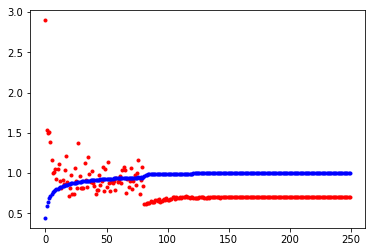

In [10]:
# y_loss에 학습셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()
# loss: 1.5541 - acc: 0.4574
# 그냥 baseline 그대로 돌리면 loss 1.4783 acc 0.5014
# loss: 0.4548 - acc: 0.8858 - val_loss: 0.4985 - val_acc: 0.8768 확실히 성능 개선됨

# lr 달리 줬더니 그림이 저렇게 나옴.....

In [11]:
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

12000/12000 [==============================] - 3s 215us/step

Test result: 88.242 loss: 0.702
